# **NYU ECE-GY 9483 Spring 2025: Lab3 Knowledge Distillation with Quantization and Deployment on Raspberry Pi**

### Name: Joshua Manogaran
### Netid: jm10765

## **Introduction**



In this lab, we will explore the concept of **knowledge distillation** in deep learning, which involves transferring the knowledge from a large, complex teacher model to a smaller, more efficient student model. Our primary goals are to apply **quantization techniques**—both integer and floating-point—to optimize the student model, and ultimately deploy it on a **Raspberry Pi** for real-world applications.

### Objectives:
- **Understand Knowledge Distillation:** Learn how a teacher model can guide a student model to achieve comparable performance with fewer parameters.
- **Apply Quantization:** Implement both integer and floating-point quantization to reduce model size and improve inference efficiency.
- **Deploy on Raspberry Pi:** Prepare and deploy the quantized model on a Raspberry Pi, making it suitable for edge computing.
- **Integrate Learning Resources:** Access additional readings and resources for a deeper understanding of the topics.

### Lab Outline:
1. **Introduction and Objectives:** Overview of the lab, key concepts, and goals. *(This section)*
2. **Teacher-Student Model Setup:** Detailed explanation and integration of the pre-developed teacher and student models.  
   *(Your custom code for model definitions will be incorporated in this section.)*
3. **Knowledge Distillation Process:** Step-by-step guide on transferring knowledge from the teacher to the student model.
4. **Quantization Techniques:** Applying integer and floating-point quantization methods to the student model.
5. **Deployment on Raspberry Pi:** Instructions on setting up the Raspberry Pi environment, including necessary software installations and configuration.
6. **Evaluation and Results:** Analyze the performance improvements and efficiency gains after applying quantization and deployment.
7. **Additional Resources:** A curated list of readings and online resources for further study.


***Please upload your ipynb file for Lab 3 to Brightspace. Name the file as "YourNetid_lab_3.ipynb" and ensure it is submitted by April 3th at 11:59 PM.***

### Recommended Readings and Resources:


For additional background and deeper insights into the techniques we’ll use, consider reviewing these online resources:
- [Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531)
- [Quantization of Deep Neural Networks for Efficient Inference](https://arxiv.org/abs/1712.05877)
- [TensorFlow Lite Model Optimization](https://www.tensorflow.org/lite/performance/model_optimization)
- [Getting Started with Raspberry Pi for Machine Learning](https://www.raspberrypi.org/documentation/usage/gpio/)[link text](https://)

# **Visualizing Our Lab**

The following diagram illustrates the structured flow of our **Knowledge Distillation and Quantization** process:

![Workflow Diagram](https://drive.google.com/uc?id=1JbrMv9g4oA2V2PYI46MjitLRR2DeJK2U)

---

### **1. Train Teacher Model (ResNet-18)**
We begin by training a **ResNet-18** model, which serves as the **teacher model**. It is trained on the dataset to learn complex patterns and generate **soft labels** for knowledge distillation.

### **2. Extract Soft Labels (Knowledge Distillation)**
Instead of using standard hard labels, we extract **soft labels** from the teacher model. These soft labels contain richer information, allowing the student model to learn **more effectively**.

### **3. Define Student Model (MobileNetV2)**
A **lightweight student model (MobileNetV2)** is defined. This model will replicate the knowledge of the teacher model but with **fewer parameters** and improved efficiency.

### **4. Train Student Model using KD**
The student model is trained using **Knowledge Distillation (KD)**, where it learns from both:
   - The **original dataset** (hard labels).
   - The **soft labels** produced by the teacher model.

### **5. Apply Quantization**
To optimize the student model for edge deployment, we apply two different types of **quantization**:
   - **Float-16 Quantization**: Reduces model size while maintaining floating-point precision.
   - **INT-8 Quantization**: Further compresses the model to improve efficiency on low-power devices.

### **6. Deploy Quantized Models on Raspberry Pi**
The quantized models are deployed on the **Raspberry Pi**, where each version (Float-16 and INT-8) is tested for performance.

### **7. Run Inference on Raspberry Pi**
Finally, the Raspberry Pi executes real-time inference using the quantized models, allowing efficient **low-latency predictions** in an embedded environment.


# **Initialization**

In this section, we install and import all required dependencies. This cell sets up the environment to ensure that the necessary packages are available for the lab. Since we are using Google Colab, these commands will automatically install missing libraries.




In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Knowledge Distillation : Teacher Model**

## What are teacher models ?


Teacher models are typically large, high-capacity neural networks that achieve high accuracy on complex datasets. In knowledge distillation, the teacher model serves as a reference from which a smaller, more efficient student model learns. Although the teacher model might be computationally heavy, its robust performance makes it ideal for guiding the training of the student model. In this lab, while we will eventually work with a ResNet‑18 architecture for the teacher model, here’s a sample implementation using a simpler Convolutional Neural Network (CNN) to illustrate the overall approach.

## Sample Teacher Model Implementation (Simple CNN)

In [2]:
# Define the simple teacher model
def simple_teacher_model(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create and compile the teacher model
teacher_model = simple_teacher_model()
teacher_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Load and normalize CIFAR‑10 data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

# Train the teacher model
history = teacher_model.fit(train_images, train_labels,
                            epochs=5,
                            batch_size=64,
                            validation_data=(test_images, test_labels))

# Evaluate the model on the test data
test_loss, test_acc = teacher_model.evaluate(test_images, test_labels, verbose=2)
print("Test accuracy:", test_acc)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.3829 - loss: 1.6978 - val_accuracy: 0.5875 - val_loss: 1.1681
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6107 - loss: 1.1169 - val_accuracy: 0.6526 - val_loss: 0.9940
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6665 - loss: 0.9500 - val_accuracy: 0.6697 - val_loss: 0.9507
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7110 - loss: 0.8364 - val_accuracy: 0.6930 - val_loss: 0.8845
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7359 - loss: 0.7550 - val_accuracy: 0.7082 - val_loss: 0.8560
313/313 - 1s - 4ms/step - accuracy: 0.7082 - loss: 0.8560
Test accuracy: 0.7081999778747559


### Evaluating the Sample Teacher Model Performance

Our simple CNN teacher model achieved about **65% - 70% accuracy** on CIFAR‑10. For effective knowledge distillation, it's crucial to have a high-performing teacher because:

- **Enhanced Guidance:** A more accurate teacher provides richer and more reliable soft targets for the student.
- **Better Representations:** High accuracy suggests that the teacher has learned robust feature representations, which are vital for the student to mimic.
- **Performance Benchmark:** A significant performance gap between teacher and student drives the student to learn and improve.

In our next steps, we will work on refining the teacher model (using architectures like ResNet‑18) to ensure it sets a strong foundation for the student model.


# Part 1. **Teacher Model Implementation – ResNet‑18 ( 20 Marks )**
### **You need to achieve accuracy of at least 90 percent for the Teacher Model**

The provided skeleton is based on the ResNet‑18 architecture, which is a popular and effective model for image classification tasks. This model is known for its residual connections, which help alleviate the vanishing gradient problem and allow for the training of deeper networks. You can implement the skeleton as provided to achieve an accuracy of at least 85% on CIFAR‑10. Alternatively, if you prefer, you may choose to use another teacher model of your liking—as long as you ensure that its performance is high and that you save it in the same format (i.e., as teacher_model.keras).



**Disclaimer:** Below, a skeleton is provided for you. You can implement it as is to achieve an accuracy of at least 90%, or you may choose any other teacher model of your preference and save it as `teacher_model.keras`. Achieving good accuracy is crucial for effective knowledge distillation.


***Section 1 - 5 marks***

In [3]:
##############################################
# Section 1: Residual Block
##############################################

def resnet_block(inputs, filters, strides=1):
    x = layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # TODO: Add another convolution layer
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)


    # TODO: Add batch normalization
    x = layers.BatchNormalization()(x)

    # TODO: Handle shortcut connection if shape changes
    shortcut = inputs
    if inputs.shape[-1] != filters or strides != 1:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=strides, use_bias=False)(inputs)
        shortcut = layers.BatchNormalization()(shortcut)

    # TODO: Merge shortcut and main path
    x = layers.Add()([x, shortcut])

    # TODO: Apply activation
    x = layers.ReLU()(x)

    return x

***Section 2 - 10 marks***

In [4]:
##############################################
# Section 2: ResNet‑18 Model
##############################################

def ResNet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # TODO: Add residual blocks for Group 1
    x = resnet_block(x, filters=64, strides=1)
    x = resnet_block(x, filters=64, strides=1)

    # TODO: Add residual blocks for Group 2
    x = resnet_block(x, filters=128, strides=2)
    x = resnet_block(x, filters=128, strides=1)

    # TODO: Add residual blocks for Group 3
    x = resnet_block(x, filters=256, strides=2)
    x = resnet_block(x, filters=256, strides=1)

    # TODO: Add residual blocks for Group 4
    x = resnet_block(x, filters=512, strides=2)
    x = resnet_block(x, filters=512, strides=1)

    # TODO: Add global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # TODO: Add final dense layer
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model


***Section 3 - 5 marks***

In [5]:
# @title
##############################################
# Section 3: Compile and Train the Teacher Model
##############################################

# TODO: Create the model
teacher_model = ResNet18()

# TODO: Compile with a suitable optimizer and loss function
teacher_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Provided: Load and normalize CIFAR‑10 data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

# Provided: Set up data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.1
)

datagen.fit(train_images)

# TODO: Train your model using the augmented data
history = teacher_model.fit(
    datagen.flow(train_images, train_labels, batch_size=64),
    epochs=10,
    validation_data=(test_images, test_labels)
)



Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 100s 97ms/step - accuracy: 0.4136 - loss: 1.6543 - val_accuracy: 0.2868 - val_loss: 3.2959
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.6618 - loss: 0.9500 - val_accuracy: 0.6383 - val_loss: 1.1200
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 77ms/step - accuracy: 0.7359 - loss: 0.7485 - val_accuracy: 0.7319 - val_loss: 0.7600
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.7789 - loss: 0.6422 - val_accuracy: 0.7579 - val_loss: 0.7230
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.8030 - loss: 0.5668 - val_accuracy: 0.7695 - val_loss: 0.7051
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.8247 - loss: 0.5085 - val_accuracy: 0.7860 - val_loss: 0.6545
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 77ms/step - accuracy: 0.8427 - loss: 0.4593 - val_accuracy: 0.8288 - val_loss: 0.4988
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 77ms/step - accuracy: 0.8506 - loss: 0.4320 - val_accura

***Section 4 - Provided***

In [6]:
##############################################
# Section 4: Save the Trained Model
##############################################

# Save the trained teacher model
teacher_model.save('teacher_model.keras')
print("Teacher Model Trained and Saved.")

Teacher Model Trained and Saved.


# Part 2. **Knowledge Distillation Process**

In this section, you'll implement the teacher–student training loop using knowledge distillation. First, review the complete example below, which demonstrates how to define a custom Distiller class, and loss function. Then, you'll see a skeleton version with TODOs where you are required to fill in some key parts.


# **Knowledge Distillation: An Overview**

## **What is Knowledge Distillation?**
Knowledge distillation is a model compression technique where a **large, complex model (teacher)** transfers its learned knowledge to a **smaller, more efficient model (student)**. Instead of training the student model solely on ground-truth labels, distillation incorporates **soft labels**—the probability distributions output by the teacher. These soft labels provide additional information about the relationships between classes, making the student model more generalizable.

---

## **1. The Distillation Loss Function**

To effectively transfer knowledge, the student model is trained using a **distillation loss** that minimizes the difference between the teacher’s and student’s probability distributions. This is typically measured using **Kullback-Leibler (KL) divergence**.

### **Mathematical Formulation**
Let:
- $ z_i^T $ and $ z_i^S $ be the logits (pre-softmax outputs) from the teacher and student models for class $ i $.

We introduce a **temperature factor** $ T $, which smooths the probability distributions:

$$
\tilde{z}_i = z_i \Big/ T
$$

### **Softmax and Log-Softmax**

The teacher’s and student’s softened probability distributions are obtained using the **softmax function**:

$$
p_i^{(T)} = e^{\tilde{z}_i^T} \Big/ \sum_{j} e^{\tilde{z}_j^T}
$$

$$
q_i^{(T)} = e^{\tilde{z}_i^S} \Big/ \sum_{j} e^{\tilde{z}_j^S}
$$

Where:
- $ p_i^{(T)} $ represents the teacher’s softened probability distribution.
- $ q_i^{(T)} $ represents the student’s softened probability distribution.

### **KL Divergence Calculation**
The **KL divergence** measures the difference between these distributions:

$$
D_{KL}(P^{(T)} || Q^{(T)}) = \sum_{i} p_i^{(T)} \log \Big( p_i^{(T)} \Big/ q_i^{(T)} \Big)
$$

### **Final Distillation Loss**
The final **distillation loss** is:

$$
L_{\text{distill}} = T^2 \cdot D_{KL}(P^{(T)} || Q^{(T)})
$$

where the factor $ T^2 $ ensures that the gradients remain properly scaled.

---

## **2. Structure of the Distillation Process**

A knowledge distillation framework typically consists of two main components:

### **2.1 Teacher Model**
- A **pretrained, larger model** that has already been trained on the dataset.
- Provides **soft probability distributions** as supervision for the student.
- Remains **frozen** during student training.

### **2.2 Student Model**
- A **smaller, lightweight model** designed to approximate the teacher’s behavior.
- Learns using a combination of **hard loss (ground truth labels)** and **soft loss (distillation loss).**

The total loss function used to train the student is a **weighted sum** of these two losses:

$$
L_{\text{total}} = \alpha L_{\text{hard}} + (1 - \alpha) L_{\text{distill}}
$$

where:
- $ \alpha $ balances the contribution of the **hard loss** (standard classification loss) and **distillation loss**.
- $ L_{\text{hard}} $ is the normal classification loss, such as cross-entropy.

---

## **3. High-Level Structure of a Distillation Framework**
The typical implementation follows this structure:

### **Step 1: Compute Teacher Predictions**
- The teacher model generates probability distributions $ P^{(T)} $.

### **Step 2: Compute Student Predictions**
- The student model generates probability distributions $ Q^{(T)} $.

### **Step 3: Compute Losses**
- Compute **hard loss** using standard classification loss.
- Compute **soft loss** using KL divergence between teacher and student outputs.

### **Step 4: Update Student Model**
- Compute gradients with respect to the student model’s parameters.
- Optimize the student using a **gradient descent optimizer**.

---

## **4. Why Does Distillation Work?**
1. **Softer Supervision**  
   - The teacher provides additional learning signals through probability distributions, not just hard labels.

2. **Regularization Effect**  
   - The student learns a **smoother function**, making it more robust to noise.

3. **Efficient Compression**  
   - The student retains **essential knowledge** from the teacher while reducing model size.

---

 **Try implementing a distillation pipeline based on these principles!**


# Part 3. **Working on our own Student Model, Distiller Class and Loss function (30 marks)**

> ### **Make sure you acheive 75% accuracy for student model after distillation**




## 1) Load the Teacher Model

Make sure you have downloaded the `teacher_model_resnet18.keras` file from Colab and placed it in your working directory. In this section, we load the teacher model and freeze its weights because we won’t train it further.


In [7]:
#####################################
# 1) LOAD TEACHER MODEL FROM FILE   #
#####################################


#Make sure you have "teacher_model.keras" in your working directory.
teacher_model = tf.keras.models.load_model("teacher_model.keras")
teacher_model.trainable = False  # Freeze the teacher model


## 2) Create the Student Model

Here, we define a lightweight student model using MobileNetV2. You can tweak this architecture or use another model if you prefer. The student model will be trained using knowledge distillation.


In [8]:
#####################################
# 2) CREATE A STUDENT MODEL         #
#####################################
from tensorflow.keras.applications import MobileNetV2

def create_student_model():
    """
    Create a lightweight student model based on MobileNetV2.
    You can modify or extend this architecture as needed.
    """
    # Use MobileNetV2 as the base model without pre-trained weights.
    base_model = MobileNetV2(weights=None, include_top=False, input_shape=(32, 32, 3))
    x = layers.GlobalAveragePooling2D()(base_model.output)
    # modify or add extra layers.
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

student_model = create_student_model()


## 3) Define the Distiller Class (20 marks)

The distiller class handles the custom training loop for knowledge distillation. It calculates a combined loss from:
- **Hard Loss:** The standard loss between the student's predictions and the true labels.
- **Soft Loss:** The distillation loss between the teacher’s and student's predictions (using KL divergence).

Complete the TODOs to implement the missing parts.


In [9]:
#####################################
# 3) DEFINE THE DISTILLER CLASS     #
#####################################
class Distiller(tf.keras.Model):
    """
    Handles the custom training loop for knowledge distillation:
    - Uses teacher predictions (soft targets).
    - Uses student predictions.
    - Calculates a combined loss (hard + soft).
    """
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.student = student
        self.teacher = teacher

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data

        # Obtain teacher predictions (teacher is frozen)
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # TODO: 1) Compute student predictions for x.
            student_predictions = self.student(x, training=True)

            # TODO: 2) Compute the "hard" loss
            student_loss = self.student_loss_fn(y, student_predictions)

            # TODO: 3) Compute the "soft" loss (distillation loss)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
                self.temperature
            )

            # TODO: 4) Combine the two losses (hard and soft)
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # TODO: 5) Compute gradients and update the student model's trainable variables.
        gradients = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))

        # Update metrics
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results["loss"] = loss
        return results

    def test_step(self, data):
        x, y = data
        # TODO: 1) Compute student predictions in inference mode.
        y_pred = self.student(x, training=False)

        # TODO: 2) Compute the student loss comparing y_pred to y.
        student_loss = self.student_loss_fn(y, y_pred)

        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)
        results = {m.name: m.result() for m in self.metrics}
        results["loss"] = student_loss
        return results



## 4) Define Loss Functions (10 marks)

Define the loss functions used in the distillation process:
- **Hard Loss:** Standard loss between student predictions and true labels.
- **Distillation Loss:** Uses KL divergence to measure the difference between the softened predictions of the teacher and student.


In [10]:
#####################################
# 4) DEFINE LOSS FUNCTIONS          #
#####################################
# Hard label loss (student vs. ground truth)

student_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Distillation loss function (KL divergence)
def distillation_loss_fn(teacher_logits, student_logits, temperature):
    """
    Compute the distillation loss using KL divergence.
    """
    # TODO: Compute teacher probabilities using softmax with temperature scaling.
    teacher_probs = tf.nn.softmax(teacher_logits / temperature, axis=1)

    # TODO: Compute student log-probabilities using log-softmax with temperature scaling.
    student_log_probs = tf.nn.log_softmax(student_logits / temperature, axis=1)

    # TODO: Compute the KL divergence loss and return it.
    kl = tf.reduce_mean(tf.reduce_sum(teacher_probs * student_log_probs, axis=1))


    return kl


## 5) Compile & Train the Distiller

In this final section, we create an instance of the Distiller, compile it, and train it using the CIFAR-10 dataset. Optionally, data augmentation is applied.


In [11]:
#####################################
# 5) COMPILE & TRAIN DISTILLER      #
#####################################
# Create the Distiller instance.
distiller = Distiller(student=student_model, teacher=teacher_model)

# Compile the distiller.
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=student_loss_fn,
    distillation_loss_fn=distillation_loss_fn,
    alpha=0.1,       # Weight for the hard loss
    temperature=3    # Temperature for softening teacher predictions
)

# Load and normalize CIFAR-10 dataset.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

# Optional: Data augmentation.
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(train_images)

# TODO: Train the distiller using the data generator.
distiller.fit(
    datagen.flow(train_images, train_labels, batch_size=64),
    epochs=20,
    validation_data=(test_images, test_labels)
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


782/782 ━━━━━━━━━━━━━━━━━━━━ 113s 86ms/step - sparse_categorical_accuracy: 0.2208 - loss: -1.8798 - val_loss: 2.3143
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 94s 49ms/step - sparse_categorical_accuracy: 0.3958 - loss: -1.9120 - val_loss: 2.3667
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - sparse_categorical_accuracy: 0.4532 - loss: -1.9248 - val_loss: 2.3010
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - sparse_categorical_accuracy: 0.5000 - loss: -1.9356 - val_loss: 2.2079
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - sparse_categorical_accuracy: 0.5320 - loss: -1.9423 - val_loss: 2.1814
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - sparse_categorical_accuracy: 0.5643 - loss: -1.9503 - val_loss: 1.7101
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - sparse_categorical_accuracy: 0.5917 - loss: -1.9567 - val_loss: 0.6810
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - sparse_categorical_accuracy: 0.6112 - loss: -1.9634 - val_loss: 1

In [12]:
#####################################
# 6) SAVE STUDENT MODEL & TFLITE    #
#####################################

# Save the distilled student model
student_model.save("student_model.keras")
print("Student model saved.")

Student model saved.


# Part 4. **TensorFlow Lite Quantization ( 10 marks )**

In this section, we convert the saved student model to TensorFlow Lite format using two different quantization methods:
- **Float16 Weight-Only Quantization:** Converts model weights from float32 to float16.
- **INT8 Weight-Only Quantization:** Converts model weights to int8 using a representative dataset for calibration while keeping activations in float32.

Review the code, then complete the TODO sections with appropriate settings or modifications as needed.


***Section 1 - 5 marks***

In [13]:
# -------------------------------
# Float16 Weight-Only Quantization
# -------------------------------

# TODO: 1) Load the student model from a saved Keras model file.
student_model = tf.keras.models.load_model("student_model.keras")

# TODO: 2) Create a TFLite converter from the student model.
converter = tf.lite.TFLiteConverter.from_keras_model(student_model)

# TODO: 3) Set the converter optimizations to enable model compression.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# TODO: 4) Define the target data type for quantization (e.g., float16 for weight-only quantization).
converter.target_spec.supported_types = [tf.float16]

# TODO: 5) Convert the model to TFLite format.
tflite_model = converter.convert()

# Save the converted TFLite model to a file.
with open('student_model_float16_weights_only.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpp94j1dbz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138747953735120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138747953735312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138747953740112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138747953734544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138747953740304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138745694625360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138745694628240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138744683816976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138745694627280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138745694628048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13874468381332

***Section 2 - 5 marks***

In [14]:
# -------------------------------
# INT8 Weight-Only Quantization
# -------------------------------

# TODO: 1) Load the student model from a saved Keras model file.
student_model = tf.keras.models.load_model("student_model.keras")

# TODO: 2) Load the CIFAR-10 test dataset for calibration.
(_, _), (test_images, _) = tf.keras.datasets.cifar10.load_data()
test_images = test_images / 255.0  # Normalize pixel values

# TODO: 3) Define a representative dataset generator for calibration.
def representative_data_gen():
    # Verify if 100 images are sufficient for calibration or adjust the count.
    for i in range(100):
        yield [test_images[i:i+1].astype(np.float32)]

# TODO: 4) Create a TFLite converter from the student model.
converter = tf.lite.TFLiteConverter.from_keras_model(student_model)

# TODO: 5) Set the converter optimizations for weight quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# TODO: 6) Assign the representative dataset generator for calibration.
converter.representative_dataset = representative_data_gen

# TODO: 7) Set the target operations to use only INT8 built-in ops.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# TODO: 8) Keep activations as float32 for compatibility, unless full INT8 quantization is needed.
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# TODO: 9) Convert the model to TFLite format.
tflite_model = converter.convert()

# Save the converted TFLite model to a file.
with open('student_model_int8_weights_only_cifar.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmp4rrnczek'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138745694307152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138745694310608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138745694310992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138745694310800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138745694308880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138745694309264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138745694312912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138745694313296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138745694313104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138745694307344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13874569431444

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


# Part 5. **Raspberry Pi Setup on Mythic Beasts ( 40 mark )**





In this section, we will set up a Raspberry Pi 4 server through [Mythic Beasts](https://www.mythic-beasts.com/order/rpi/). This server will be used to deploy and run our quantized TensorFlow Lite models. Follow the steps below to get started.

### 1. Purchase a Raspberry Pi 4 (8 GB) Server ( approx 10 pounds )
- Go to [Mythic Beasts Raspberry Pi](https://www.mythic-beasts.com/order/rpi/).
- Choose the **Raspberry Pi 4 with 8 GB RAM** monthly plan.
- Complete the checkout process to finalize your purchase.

### 2. Name Your Server
- During setup, you will have the option to name your server.
- **Important:** Use the format `netid_lab3` to clearly identify your server for this lab.
- Verify that the name is correct before proceeding.

### 3. Generate SSH Keys ( Mac )
To securely connect to your Raspberry Pi server, you will need SSH keys:

- Open a terminal (on macOS/Linux) or use Git Bash/PowerShell (on Windows).
- Generate a new SSH key pair (if you don’t already have one) by running:

  ```bash
  ssh-keygen -t rsa -b 4096
  ```
Press Enter to accept the default file location or specify a custom path.

### 4. Add Your SSH Public Key to Mythic Beasts
1. Log in to your **Mythic Beasts** account and navigate to the **SSH Keys** section under **Servers**.
2. Click the option to **Add a New Key**.
3. Paste the **public** portion of your SSH key (the content of `~/.ssh/id_rsa.pub` or equivalent) into the key field.
4. Save the changes.

### 5. Connect to Your Raspberry Pi ( Mac )
Once your server is set up and the SSH keys are in place:

1. Obtain your **Raspberry Pi server’s IP address** from the Mythic Beasts control panel.
2. Open a terminal and connect via SSH:

   ```bash
   ssh -i ~/.ssh/id_rsa <username>@<your_pi_server_ip>

3. Replace:
~/.ssh/id_rsa with the path to your private key if different.
<username> with the username provided by Mythic Beasts (e.g., netid_lab3).
<your_pi_server_ip> with the IP address of your Raspberry Pi.

These configurations are also provided by mythic beasts

# 1) Transferring Files to Raspberry Pi using SCP

To transfer files from your local machine to a Raspberry Pi hosted by Mythic Beasts, use the `scp` (Secure Copy Protocol) command.

## Command Format

```sh
scp -i ~/your-key-file -P 5400 "/path/to/local/file" root@ssh.your-hostedpi.com:/path/to/destination/
```
## Example Command
``` sh
scp -i ~/.ssh/mythic_key -P 5400 "~/Documents/my_script.py" root@ssh.examplepi.com:/home/pi/
```
### Important Instructions:
- Ensure that the file transfer completes **100%** before proceeding.
- If the `scp` command is interrupted or incomplete, your files may be **corrupted**, leading to runtime errors.
- Always **wait for the command to fully execute** before disconnecting.

## **NOTE** :
For now transfer both the **"student_model_int8_weights_only_cifar.tflite"** and **"student_model_float16_weights_only.tflite"** to the raspberry pi using SCP command. The above setup was for macos it follows similarly for windows systems as well you can find it online i.e (how to setup scp,ssh etc ).

# 2) Downloading Images on Raspberrypi to run Inference

Run the following code on raspberry pi

In [ ]:
mkdir -p images

wget -O images/image1_frog.jpg https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog1.png
wget -O images/image2_automobile.jpg https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile1.png
wget -O images/image3_truck.jpg https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck1.png
wget -O images/image4_airplane.jpg https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane1.png
wget -O images/image5_ship.jpg https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship1.png
wget -O images/image6_deer.jpg https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer1.png
wget -O images/image7_dog.jpg https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog1.png
wget -O images/image8_horse.jpg https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse1.png
wget -O images/image9_bird.jpg https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird1.png
wget -O images/image10_cat.jpg https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat1.png


# 3) Attach Screenshots of Your Setup Displaying Your NetID (10 Marks)

Your submission should include the following screenshots:

1. **Server Displaying Your NetID (`netid_lab3`)**  
   - Show the terminal where your server is named as `netid_lab3`.

2. **SSH Login Screenshot**  
   - A terminal screenshot where you are logged into your server via SSH.

3. **`wget` Command for Downloading Images**  
   - A screenshot showing the execution of the `wget` command to download the required images.

4. **SCP Command for Transferring `.tflite` Models to the PO**  
   - Use the following command to transfer your TensorFlow Lite models from your local machine to the Pi:  



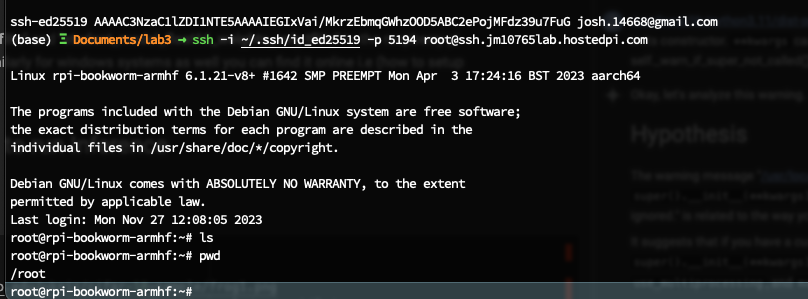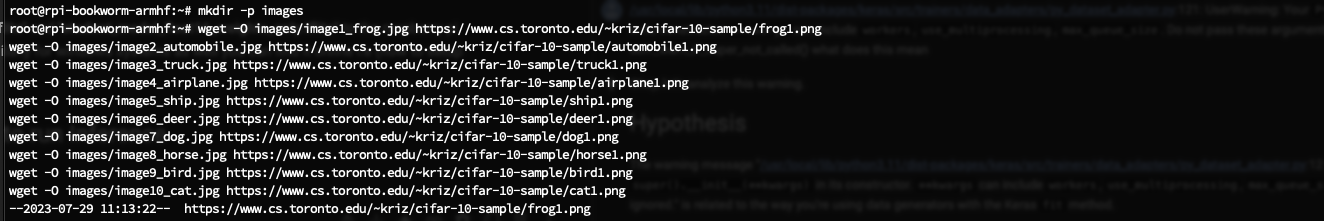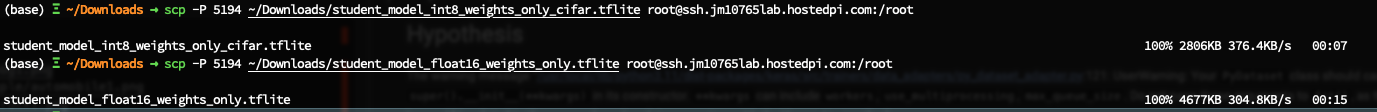

# 4) Running Inference on Raspberry Pi ( 20 marks )

After transferring the **TFLite models** and downloading the **images**, the next step is to **run inference** using the `Inference.py` script.

---

## **Setup Requirements**
Ensure that:
- The **quantized models** (`student_model_float16_weights_only.tflite`, `student_model_int8_weights_only_cifar.tflite`) are in the working directory.
- The **test images** are inside the `images/` folder.
- The required **libraries** (`tflite_runtime`, `PIL`, `numpy`, `psutil`, `shutil`) are installed.

---

## **Implement & Transfer Inference Script**
Now, complete the **TODOs in `Inference.py`** to:
- Load the **TFLite models**.
- Preprocess images and run inference.
- Measure CPU, memory, and temperature usage.

Once completed, **transfer `Inference.py` to the Raspberry Pi using SCP** and run inference to analyze performance.

 **Complete the script, transfer it, and start running inference!**


***Section 1 - 10 marks (complete run inference function )***

In [4]:
from tflite_runtime.interpreter import Interpreter
from PIL import Image
import numpy as np
import time
import os
import psutil
import shutil

# List of models to test
models = [
    "student_model_float16_weights_only.tflite",
    "student_model_int8_weights_only_cifar.tflite"
]

# Path to images folder
image_folder = "images/"
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))])

# Ensure images exist
if not image_files:
    print("No images found in the 'images/' folder. Please add images before running inference.")
    exit()

# Function to get CPU temperature
def get_cpu_temp():
    try:
        with open("/sys/class/thermal/thermal_zone0/temp", "r") as f:
            return int(f.read().strip()) / 1000.0  # Convert from millidegrees to Celsius
    except Exception:
        return None

# Function to preprocess images
def preprocess_image(image_path, input_shape, dtype=np.float32):
    """Load and preprocess an image to match the model's expected input shape."""
    img = Image.open(image_path).resize((input_shape[1], input_shape[2]))
    img_array = np.array(img).astype(dtype) / 255.0  # Normalize

    # INT8 models require int8 inputs, so scale correctly
    if dtype == np.int8:
        img_array = (img_array * 255 - 128).astype(np.int8)

    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# -------------------------------
# Function to run inference
# -------------------------------

def run_inference(model_path, image_path):
    """Run inference on a quantized TFLite model and collect performance data."""
    try:
        # TODO: 1) Load the TFLite model using the Interpreter.
        interpreter = Interpreter(model_path=model_path)

        # TODO: 2) Allocate memory for model tensors.
        interpreter.allocate_tensors()

        # TODO: 3) Retrieve model input and output tensor details.
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # TODO: 4) Extract input shape and data type.
        input_shape = input_details[0]['shape']
        input_dtype = input_details[0]['dtype']

        # TODO: 5) Load and preprocess the image to match the model’s input format.
        sample_input = preprocess_image(image_path, input_shape, input_dtype)

        # TODO: 6) Measure CPU and memory usage before inference.
        cpu_before = psutil.cpu_percent()
        mem_before = psutil.virtual_memory().percent
        temp_before = get_cpu_temp()

        # TODO: 7) Perform inference:
        #  - Start timer
        #  - Set the input tensor
        #  - Invoke the model
        #  - End timer
        start_time = time.time()

        interpreter.set_tensor(input_details[0]['index'], sample_input)
        interpreter.invoke()

        end_time = time.time()

        # TODO: 8) Retrieve the output tensor from the model.
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # TODO: 9) Determine the predicted class from the output.
        predicted_class = np.argmax(output_data)

        # TODO: 10) Measure CPU and memory usage after inference.
        cpu_after = psutil.cpu_percent()
        mem_after = psutil.virtual_memory().percent
        temp_after = get_cpu_temp()

        return {
            "model": model_path,
            "image": os.path.basename(image_path),
            "inference_time": round(end_time - start_time, 4),
            "predicted_class": predicted_class,
            "cpu_before": cpu_before,
            "cpu_after": cpu_after,
            "mem_before": mem_before,
            "mem_after": mem_after,
            "temp_before": temp_before,
            "temp_after": temp_after
        }

    except Exception as e:
        print(f"Inference failed for {model_path} on {image_path}: {e}")
        return None


# Store results for final summary
results = []

# Run inference on all images using both models
for model in models:
    print(f"\nRunning inference with model: {model}\n" + "="*60)
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        result = run_inference(model, image_path)
        if result:
            results.append(result)

# Final Summary Table
shutil.get_terminal_size((80, 20))  # Ensure table formatting works well
print("\nFinal Inference Summary")
print("=" * 80)
print(f"{'Model':<40} {'Image':<20} {'Time (s)':<10} {'Pred Class':<12} {'CPU (%)':<12} {'Mem (%)':<10} {'Temp (°C)':<10}")
print("=" * 80)

for res in results:
    print(f"{res['model']:<40} {res['image']:<20} {res['inference_time']:<10} {res['predicted_class']:<12} {res['cpu_after']:<12} {res['mem_after']:<10} {res['temp_after']:<10}")

print("=" * 80)
print("Inference Completed.")


ModuleNotFoundError: No module named 'tflite_runtime'

# 5) Inference Results and answer the questions (10 marks)
## **Attach screenshots of your raspberry pi outputs**


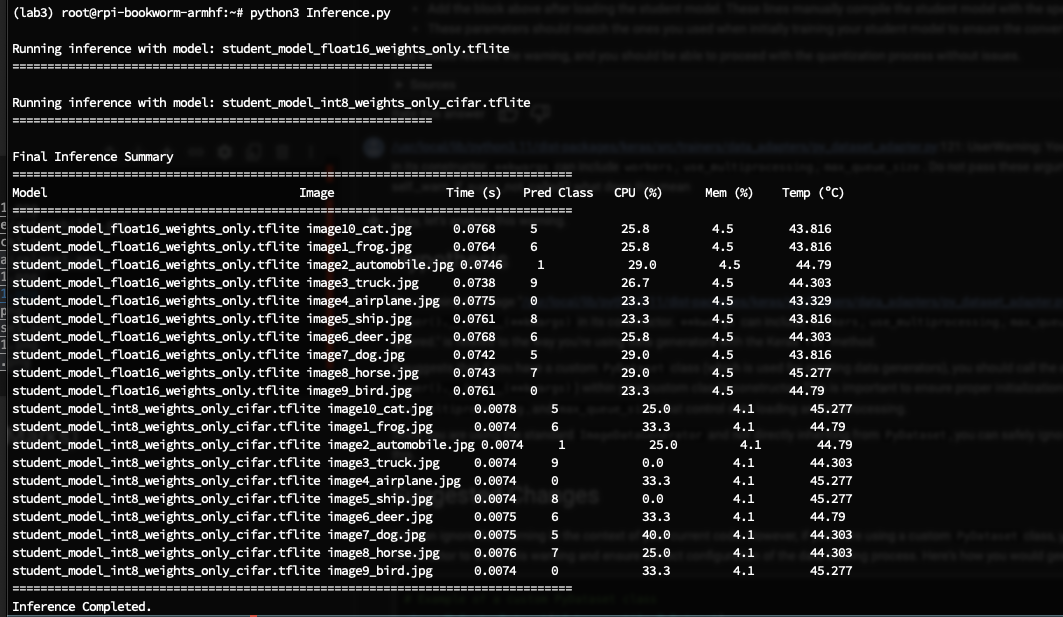

### Instructions:
- Review the summary table generated after running the inference.
- Compare the performance of the 2 different models and analyze the resource usage.

### Key Observations:
1. **Inference Time:** Compare the execution times for different models. Which model runs faster? How does quantization affect speed?
INT8 Runs faster, by using 8 bit ints instead of 16 bit floats computation is reduced significantly on the raspberry pi.
2. **CPU and Memory Usage:** Observe CPU and memory utilization before and after inference. Do different models show significant differences in resource consumption?
CPU usage is a bit higher in the int8 model when compared to the float16. Memory usage in 0.4% less in the int 8 model.
3. **Prediction Consistency:** Look at the predicted classes. Are the models making consistent predictions across different images? Yes both model predictions are consistent.
